In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader


torch.manual_seed(0)



In [2]:
lambda_recon = 100

beta1 = 0.5
beta2 = 0.99

n_epochs = 125
input_dim = 1
real_dim = 2
display_step = 50
batch_size = 128
#lr = 0.0002
target_shape = 32
beta = 0.1
device = 'cuda'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Use GPU: {}'.format(str(device) != 'cpu'))

##########################
smoothing=0.9
#l1_weight=0.99
base_lr_gen=3e-4
base_lr_disc=6e-5
base_lr_classifier=6e-5 
lr_decay_steps=6e4
lr_decay_rate = 0.1
start_epoch = 0
num_workers = 4

Use GPU: False


In [3]:
# New parameters
adv_criterion = nn.BCEWithLogitsLoss().to(device)
classifier_criterion = nn.BCEWithLogitsLoss().to(device)
#recon_criterion = nn.L1Loss().to(device)
#adv_criterion = nn.BCELoss().to(device)
recon_criterion = nn.L1Loss().to(device)

In [4]:
import torchvision

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
num_of_iteration = len(trainloader)
num_of_iteration

391

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
from models.discriminator import Discriminator
from models.unet import UNet
from models.classifier import Classifier

gen = UNet(input_channels = input_dim, output_channels = real_dim, hidden_channels=32).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=base_lr_gen, betas=(beta1, beta2))
disc = Discriminator(input_dim+real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=base_lr_disc, betas=(beta1, beta2))
classifier = Classifier(input_dim+real_dim).to(device)
classifier_opt = torch.optim.Adam(classifier.parameters(), lr=base_lr_classifier, betas=(beta1, beta2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0.0)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        try:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        except AttributeError:
            pass
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def load_checkpoint(
    filepath,
    model,
    optimizer,
    model_state_dict_path,
    opt_state_dict_path,
    epoc_path,
    cur_step_path = "",
    mean_path = "",
    requires_grad = False
):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint[model_state_dict_path])
    optimizer.load_state_dict(checkpoint[opt_state_dict_path])
    #for parameter in model.parameters():
    #    parameter.requires_grad = requires_grad

    #model.eval()
    return model, optimizer, checkpoint[epoc_path], checkpoint[cur_step_path], checkpoint[mean_path]


# Feel free to change pretrained to False if you're training the model from scratch
pretrained = False
if pretrained:
    save_counter = 1
    gen, gen_opt , epoc, cur_step ,mean_generator_loss = load_checkpoint(
        f"/content/gdrive/MyDrive/gen_colorizing_{save_counter}_cifar_2g.pth",
        gen,
        gen_opt,
        'gen',
        'gen_opt',
        'epoch',
        'cur_step',
        'mean')
################################################################################
    disc, disc_opt, depoc, dcur_step ,mean_discriminator_loss = load_checkpoint(
        f"/content/gdrive/MyDrive/disc_colorizing_{save_counter}_cifar_2g.pth",
        disc,
        disc_opt,
        'disc',
        'disc_opt',
        'epoch',
        'cur_step',
        'mean')
################################################################################
    classifeir, classifier_opt , cepoc, ccur_step ,mean_classifier_loss = load_checkpoint(
        f"/content/gdrive/MyDrive/classifier_colorizing_{save_counter}_cifar_2g.pth",
        classifier,
        classifier_opt,
        'classifier',
        'classifier_opt',
        'epoch',
        'cur_step',
        'mean')
################################################################################
    with open(f"/content/gdrive/MyDrive/gen_loss_{save_counter}_cifar_2g.txt") as f:
        gen_loss_as_string = f.read()
    with open(f"/content/gdrive/MyDrive/disc_loss_{save_counter}_cifar_2g.txt") as f:
        disc_loss_as_string = f.read()
    with open(f"/content/gdrive/MyDrive/classifier_loss_{save_counter}_cifar_2g.txt") as f:
        classifier_loss_as_string = f.read()
else:
    gen.apply(weights_init)
    disc.apply(weights_init)
    classifier.apply(weights_init)
    gen.apply(weights_init_normal)
    disc.apply(weights_init_normal)
    classifier.apply(weights_init_normal)

    epoc = 0
    cur_step = 0
    save_counter = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    mean_classifier_loss = 0
    disc_loss_as_string = "0"
    gen_loss_as_string = "0"
    classifier_loss_as_string = "0"

In [7]:
print(len(classifier_loss_as_string.split(",")))
print(epoc)

1
0


In [8]:
def adjust_learning_rate(optimizer, global_step, base_lr, lr_decay_rate=0.1, lr_decay_steps=6e4):
    """Adjust the learning rate of the params of an optimizer."""
    lr = base_lr * (lr_decay_rate ** (global_step/lr_decay_steps))
    if lr < 1e-6:
        lr = 1e-6

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
beta = 0.1

In [10]:
from skimage import color
import numpy as np
from utils.image_utils import show_tensor_images

def train(
    save_model,
    start_epoch,
    n_epochs,
    cur_step,
    save_counter,
    dataloader,
    mean_generator_loss,
    mean_discriminator_loss,
    mean_classifier_loss,
    gen_loss_as_string,
    disc_loss_as_string,
    classifier_loss_as_string
):
    gen.train()
    disc.train()
    classifier.train()

    for epoch in range(start_epoch, n_epochs):
        count = 0
        for image, _ in tqdm(dataloader):
            image = image.to(device)
            real = image[:,1:,:,:]#(N,C,H,W)
            condition = image[:,0:1,:,:]
            if(count != 0 and count != 1):
                raise Exception("Error, count value is not valid")
            if( count==0 ):
                gen.switch = 0
            elif(count == 1):
                gen.switch = 1

            #update generator
            adjust_learning_rate(gen_opt,
                                 cur_step, 
                                 base_lr=base_lr_gen,
                                 lr_decay_rate=lr_decay_rate,
                                 lr_decay_steps=lr_decay_steps)

            gen_opt.zero_grad()
            fake = gen(condition)
            fake_img_lab = torch.cat([condition, fake], dim=1).to(device)
            disc_fake_hat = disc(fake_img_lab)
            gen_adv_loss = adv_criterion(disc_fake_hat, torch.full_like(disc_fake_hat,0.9))
            gen_rec_loss = recon_criterion(image, fake_img_lab)
            tt = classifier(fake_img_lab)
            disc_classification_loss = classifier_criterion(tt, torch.full_like(tt,0.01 if count==0 else 0.99))
            gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss + beta*disc_classification_loss
            #gen_loss = (1.0 - l1_weight)*gen_adv_loss + (l1_weight*gen_rec_loss) + beta*disc_classification_loss
            gen_loss.backward()
            gen_opt.step()

            #update discriminator
            adjust_learning_rate(disc_opt,
                                 cur_step, 
                                 base_lr=base_lr_disc,
                                 lr_decay_rate=lr_decay_rate,
                                 lr_decay_steps=lr_decay_steps)
            disc_opt.zero_grad()
            disc_real_hat = disc(image)  
            disc_real_loss = adv_criterion(disc_real_hat, torch.full_like(disc_real_hat,0.9))
            disc_fake_hat = disc(fake_img_lab.detach())# Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_loss = (disc_fake_loss + disc_real_loss)
            disc_loss.backward()
            disc_opt.step()

            #update classifier
            adjust_learning_rate(classifier_opt,
                                 cur_step, 
                                 base_lr=base_lr_classifier,
                                 lr_decay_rate=lr_decay_rate,
                                 lr_decay_steps=lr_decay_steps)

            classifier_opt.zero_grad()
            tt = classifier(fake_img_lab.detach())
            disc_classification_loss = classifier_criterion(tt, torch.full_like(tt,0.01 if count==0 else 0.99))
            disc_classification_loss.backward() # Update gradients
            classifier_opt.step()

            count += 1
            count = count%2
          
            # Keep track of the average discriminator loss
            mean_discriminator_loss = (cur_step*mean_discriminator_loss + disc_loss.item()) / (cur_step + 1)
            disc_loss_as_string = "%s,%f" % (disc_loss_as_string,disc_loss.item())
            # Keep track of the average generator loss
            mean_generator_loss = (cur_step*mean_generator_loss + gen_loss.item()) / (cur_step + 1)
            gen_loss_as_string = "%s,%f" % (gen_loss_as_string,gen_loss.item())
            # Keep track of the average classifier loss
            mean_classifier_loss = (cur_step*mean_classifier_loss + disc_classification_loss.item()) / (cur_step + 1)
            classifier_loss_as_string = "%s,%f" % (classifier_loss_as_string,disc_classification_loss.item())

            ### Visualization code ###
            if cur_step % display_step == 0:
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    if(cur_step % 150 == 0):
                        save_counter = 0
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'epoch': epoch,
                        'cur_step': cur_step,
                        'mean': mean_generator_loss},
                        f"/content/gdrive/MyDrive/gen_colorizing_{save_counter}_cifar_2g.pth")
                    with open(f"/content/gdrive/MyDrive/gen_loss_{save_counter}_cifar_2g.txt", 'w') as f:
                        f.write(gen_loss_as_string)
                    torch.save({'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict(),
                        'epoch': epoch,
                        'cur_step': cur_step,
                        'mean': mean_discriminator_loss},
                        f"/content/gdrive/MyDrive/disc_colorizing_{save_counter}_cifar_2g.pth")
                    with open(f"/content/gdrive/MyDrive/disc_loss_{save_counter}_cifar_2g.txt", 'w') as f:
                        f.write(disc_loss_as_string)
                    torch.save({'classifier': classifier.state_dict(),
                        'classifier_opt': classifier_opt.state_dict(),
                        'epoch': epoch,
                        'cur_step': cur_step,
                        'mean': mean_classifier_loss},
                        f"/content/gdrive/MyDrive/classifier_colorizing_{save_counter}_cifar_2g.pth")
                    with open(f"/content/gdrive/MyDrive/classifier_loss_{save_counter}_cifar_2g.txt", 'w') as f:
                        f.write(classifier_loss_as_string)
                    print("save_counter:", save_counter, "cur_step:", cur_step)
                    save_counter += 1

                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Classifier loss: ,{disc_classification_loss.item()}, Generator (U-Net) loss: {gen_loss.item()}, Discriminator loss: {disc_loss.item()}")
                    print(f"Epoch {epoch}: Step {cur_step}: Classifier loss mean: ,{mean_classifier_loss}, Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss mean: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images((condition + 1.)*50., size=(3, target_shape, target_shape),f=True)
                show_tensor_images(torch.cat([(condition + 1.)*50., real*110], axis=1), size=(real_dim + input_dim , target_shape, target_shape))
                show_tensor_images(torch.cat([(condition + 1.)*50., fake*110], axis=1), size=(real_dim + input_dim, target_shape, target_shape))
            cur_step += 1



  0%|          | 0/391 [00:00<?, ?it/s]

Pretrained initial state
torch.Size([3, 32, 32])


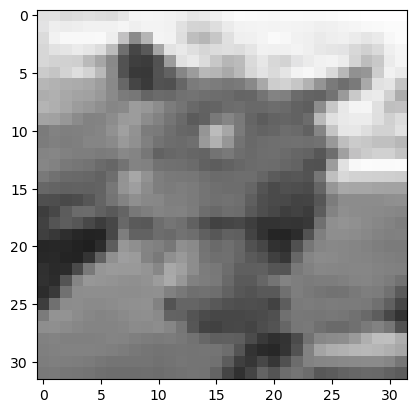

torch.Size([3, 32, 32])


/home/ali/PycharmProjects/MPGAN/utils/image_utils.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img = lab2rgb(image_tensor.permute((1, 2, 0)))


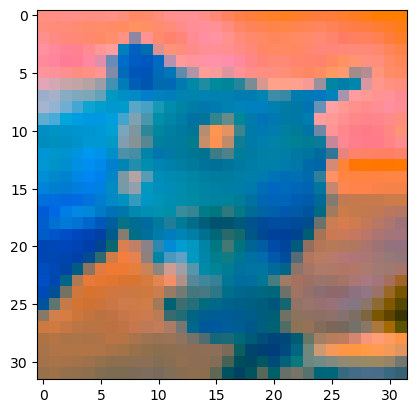

torch.Size([3, 32, 32])


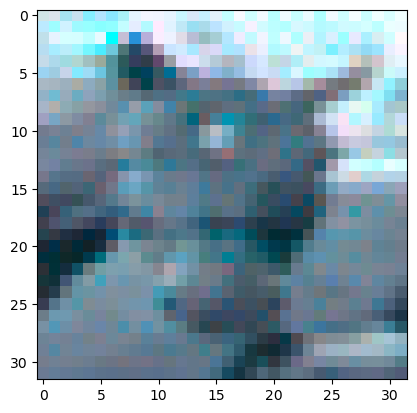

KeyboardInterrupt: 

In [11]:
train(
    save_model=False,
    start_epoch = epoc+1,
    n_epochs=n_epochs,
    cur_step=cur_step,
    #global_step = epoc*num_of_iteration + cur_step,
    save_counter = save_counter,
    dataloader = trainloader,
    mean_generator_loss = mean_generator_loss,
    mean_discriminator_loss = mean_discriminator_loss,
    mean_classifier_loss = mean_classifier_loss,
    gen_loss_as_string = gen_loss_as_string,
    disc_loss_as_string = disc_loss_as_string,
    classifier_loss_as_string = classifier_loss_as_string
)

In [ ]:
indi = torch.randint(1, 3, (batch_size,))
print(indi.tolist())